<a href="https://colab.research.google.com/github/gcvasconcelos/text_summarization/blob/main/text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sumarização automática abstrativa

Neste projeto, é proposta a aplicação de um modelo *sequence-to-sequence* usando Redes Neurais Recorrentes (RNN) implementados em uma arquitetura *encoder-decoder* com o objetivo da resolução da tarefa de sumarização automática abstrativa, ou seja, a construção de um resumo que capture o sentido e contexto presente no texto original mas que não utiliza necessariamente as palavras deste. 

Os textos estão escritos na língua portuguesa e são transcrições de pronunciamentos realizados por senadores no Senado Federal do Brasil. A base têm a característica especial de possuir um extenso vocabulário e tamanho onde, todavia, cada discurso discorre sobre pouco mais de um assunto geral. 

Para lidar com esses desafios, na fase de treinamento do modelo foi utilizado no *encoder* um conjunto de modelos *Long Short-Term Memory* (LSTM) bi-direcional que é treinado com os textos dos discursos e tem como fim capturar seu contexto, tanto do passado como do futuro. Partes importantes deste contexto são selecionadas por um mecanismo de *attention* que é utilizado para inicializar o *decoder*, uma outra LSTM que é treinada com resumos gerados por humanos. 

Os resumos foram gerados automaticamente para 14.535 discursos e avaliados a partir das métricas ROUGE e BERTScore, que tiveram um resultado satisfatório quando comparados com a literatura.


## Configuração do Ambiente

In [ ]:
!pip install unidecode
!pip install rouge
!pip install torch
!pip install transformers
import torch
import tensorflow as tf
print(f"GPU is available for torch: {torch.cuda.is_available()}")
print(f"GPU is available for tensorflow: {tf.test.gpu_device_name()}")

GPU is available for torch: True
GPU is available for tensorflow: /device:GPU:0


In [ ]:
!pip install -U spacy
!pip install -U spacy-lookups-data
!python -m spacy download pt_core_news_lg

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.3.5)
Requirement already up-to-date: spacy-lookups-data in /usr/local/lib/python3.6/dist-packages (0.3.2)
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_lg')


In [ ]:
import pandas as pd
import pickle
import time
from unidecode import unidecode
import re
import spacy
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Add
# from attention import Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from rouge import Rouge
from bert_score import score

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
!ls "/content/drive/My Drive/Colab Notebooks/"

Mounted at /content/drive/
 discursos_clean.csv	   'MT - Text Sumarization.ipynb'   word2vec_new.model
 discursos_raw_all.pickle   val_data.csv


## Pré processamento

In [ ]:
data_raw = pickle.load(open("/content/drive/My Drive/Colab Notebooks/discursos_raw_all.pickle", "rb"))
raw_df = pd.DataFrame(data_raw)
raw_df.head()

,IdentificacaoParlamentar,IdentificacaoPronunciamento,Conteudo
0,"{'CodigoParlamentar': '825', 'CodigoPublicoNaL...","{'CodigoPronunciamento': '396425', 'TipoUsoPal...",O SR. PAULO PAIM (Bloco/PT - RS. Pronuncia o s...
1,"{'CodigoParlamentar': '4697', 'NomeParlamentar...","{'CodigoPronunciamento': '400383', 'TipoUsoPal...",A SRª ANGELA PORTELA (Bloco/PT - RR. Pronuncia...
2,"{'CodigoParlamentar': '4531', 'CodigoPublicoNa...","{'CodigoPronunciamento': '410003', 'TipoUsoPal...",O SR. JAYME CAMPOS (Bloco Minoria/DEM - MT. Pr...
3,"{'CodigoParlamentar': '53', 'NomeParlamentar':...","{'CodigoPronunciamento': '386066', 'TipoUsoPal...",SENADO FEDERAL SF - SECRETARIA-GE...
4,"{'CodigoParlamentar': '4529', 'NomeParlamentar...","{'CodigoPronunciamento': '399259', 'TipoUsoPal...",O SR. CÍCERO LUCENA (Bloco/PSDB - PB) - É por...


In [ ]:
data_df = pd.DataFrame(columns=['speech', 'speech_summary'])
data_df['speech'] = raw_df['Conteudo']
data_df['speech_summary'] = [dic.get('TextoResumo') for dic in raw_df['IdentificacaoPronunciamento']]

data_df.info()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74981 entries, 0 to 74980
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   speech          74981 non-null  object
 1   speech_summary  74167 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


,speech,speech_summary
0,O SR. PAULO PAIM (Bloco/PT - RS. Pronuncia o s...,"\n Destaque à aprovação, pelo Senado Fede..."
1,A SRª ANGELA PORTELA (Bloco/PT - RR. Pronuncia...,\n Satisfação com a postura do Governo Fe...
2,O SR. JAYME CAMPOS (Bloco Minoria/DEM - MT. Pr...,"\n Apelo no sentido da aprovação, pela Câ..."
3,SENADO FEDERAL SF - SECRETARIA-GE...,\n Relato sobre as dificuldades verificad...
4,O SR. CÍCERO LUCENA (Bloco/PSDB - PB) - É por...,None


Removendo discursos sem resumos

In [ ]:
data_df = data_df[data_df['speech_summary'].notna()]
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74167 entries, 0 to 74980
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   speech          74167 non-null  object
 1   speech_summary  74167 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [ ]:
contraction_list = {
    "v\. exa": "vossa excelencia"
    ,"s\. exa": "vossa excelencia"
    , "sr\.": "senhor"
    , "srs\.": "senhores"
    , "sra\.": "senhora"
    , "sras\.": "senhoras"
    , "pag\.": "pagina"
    , "exm\.": "excelentissimo"
    , "exma\.": "excelentissima"
}

def text_cleaning(col_name, is_target=False):
    for text in data_df[col_name]:
        text = unidecode(text).lower()
        for contraction in contraction_list.keys():
            text = re.sub(contraction, contraction_list[contraction], text)

        text = re.sub(r"\\n|\\xa0", ' ', text) # remove escape characters
        text = re.sub(r"[^a-z]", ' ', text) # keep only words

        if is_target:
            text = re.sub(r"\b[a-z]{1,2}\b", ' ', text) # remove <2 characters

        text = re.sub(r"\s+", ' ', text) # remove extra spaces (at the end)
        text = text.strip()
        yield text

cleaned_speech = text_cleaning('speech', is_target=True)
cleaned_speech_summary = text_cleaning('speech_summary')

nlp = spacy.load('pt_core_news_lg', disable=['tagger', 'parser', 'ner'])

def remove_stopwords(doc, is_target=False):
    if is_target:
        corpus = [token.lemma_ for token in doc if not token.is_stop]
    else:
        corpus = [token.text for token in doc if not token.is_stop]
    return ' '.join(corpus)

t = time.time()

corpus = [remove_stopwords(doc, is_target=True) for doc in nlp.pipe(cleaned_speech, batch_size=5000, n_threads=-1)]
labels = [remove_stopwords(doc) for doc in nlp.pipe(cleaned_speech_summary, batch_size=5000, n_threads=-1)]

print(f'Processing time: {round((time.time() - t) / 60, 2)} mins')

Processing time: 12.53 mins


In [ ]:
data_df['speech_clean'] = corpus
data_df['speech_summary_clean'] = labels
data_df['speech_summary_clean'] = data_df['speech_summary_clean'].apply(lambda summ : '_START_ '+ summ + ' _END_')

for i in range(3):
    print("Speech: ",data_df['speech_clean'][i])
    print("Summary: ",data_df['speech_summary_clean'][i])
    print("\n")

Speech:  senhor paulo paim bloco pronunciar seguinte discursar revisao orador senador mozarildo cavalcanti presidir sessao senador fernando collor mello usar tribuna orador registro senhor presidente analisar detalhar importancia aprovacao senado camara projeto autista analisar fazer mediante cartar receber principal lider dizer autista pai encaminhar cartar semana sr berenice piana piana registro hoje noite estar hotel sao marcar brasilia participar solenidade posse diretoria contratuh eleito quinquenio dezembro dezembro moacyr roberto tesch atual presidente confederacao ativo participante reeleito presidencia confederacao convidar congresso nacional dezena dezena durante ano dia dezembro confederacao dar brasilia congresso nacional trabalhador turismo hospitalidade dirigente sindicar participar evento objetivo definir bandeiro contratuh defender continuar defender muito delas proximo mandatar confederacao apresentar tambem dia exposicao informativo ultimos ano janeiro dezembro fazer 

## Análise dos dados

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00cfcaf438>,
      dtype=object)

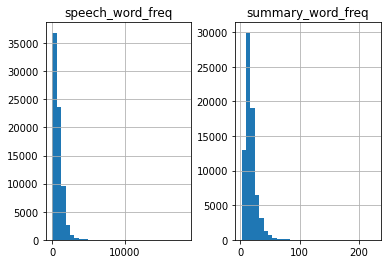

In [ ]:
data_df['speech_word_freq'] = data_df['speech_clean'].apply(lambda x : len(x.split()))
data_df['summary_word_freq'] = data_df['speech_summary_clean'].apply(lambda x : len(x.split()))
data_df[['speech_word_freq', 'summary_word_freq']].hist(bins = 30)

In [ ]:
print(f"Stats of words in speech: \n{data_df['speech_word_freq'].describe()}")
print(f"Stats of words in  summary: \n{data_df['summary_word_freq'].describe()}")

Stats of words in speech: 
count    74167.000000
mean       766.029488
std        690.937547
min          2.000000
25%        311.000000
50%        613.000000
75%       1043.000000
max      18209.000000
Name: speech_word_freq, dtype: float64
Stats of words in  summary: 
count    74167.000000
mean        17.330443
std          9.893072
min          2.000000
25%         11.000000
50%         15.000000
75%         21.000000
max        225.000000
Name: summary_word_freq, dtype: float64


In [ ]:
corpus_array = [doc.split() for doc in data_df['speech_clean']]
corpus_summ = [doc.split() for doc in data_df['speech_summary_clean']]
corpus_array.extend(corpus_summ)

word_frequency = defaultdict(int)
for sentence in corpus_array:
    for word in sentence:
        word_frequency[word] += 1
print(f"Vocabulary present in corpus: {len(word_frequency)}")
print("Most frequent words in corpus:")
sorted(word_frequency, key=word_frequency.get, reverse=True)[:15]

Vocabulary present in corpus: 151435
Most frequent words in corpus:


['nao',
 'senhor',
 'senador',
 'presidente',
 'excelencia',
 'ser',
 'governar',
 'brasil',
 'ano',
 'brasileiro',
 'pai',
 'tambem',
 'sao',
 'estar',
 'ter']

In [ ]:
first_percetile = data_df['speech_word_freq'].quantile(0.01)
last_percetile = data_df['speech_word_freq'].quantile(0.99)
data_df = data_df[(data_df['speech_word_freq'] > first_percetile)] 
data_df = data_df[(data_df['speech_word_freq'] < last_percetile)]

print(f"Removing outliers out less than {first_percetile} words and more than {last_percetile} words")
print(f"Dataset size: {data_df.shape}")

Removing outliers out less than 47.0 words and more than 3035.6999999999825 words
Dataset size: (72651, 6)


In [ ]:
print(f"Stats of words in speech: \n{data_df['speech_word_freq'].describe()}")
print(f"Stats of words in  summary: \n{data_df['summary_word_freq'].describe()}")

Stats of words in speech: 
count    72651.000000
mean       736.796548
std        550.214854
min         48.000000
25%        318.000000
50%        613.000000
75%       1033.000000
max       3034.000000
Name: speech_word_freq, dtype: float64
Stats of words in  summary: 
count    72651.000000
mean        17.340546
std          9.843429
min          2.000000
25%         11.000000
50%         15.000000
75%         21.000000
max        225.000000
Name: summary_word_freq, dtype: float64


Salvando textos de discurso e resumos limpos

In [ ]:
data_df.to_csv('/content/drive/My Drive/Colab Notebooks/discursos_clean.csv', index=False)

## Construção do Word Embedding

In [ ]:
data_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/discursos_clean.csv')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72651 entries, 0 to 72650
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   speech                72651 non-null  object
 1   speech_summary        72651 non-null  object
 2   speech_clean          72651 non-null  object
 3   speech_summary_clean  72651 non-null  object
 4   speech_word_freq      72651 non-null  int64 
 5   summary_word_freq     72651 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.3+ MB


In [ ]:
corpus_array = [doc.split() for doc in data_df['speech_clean']]
corpus_summ = [doc.split() for doc in data_df['speech_summary_clean']]
corpus_array.extend(corpus_summ)
print(f"Size of corpus of all text: {len(corpus_array)}")

Size of corpus of all text: 145302


In [ ]:
w2v_model = Word2Vec(
    min_count=10
    , window=15
    , size=100
    , workers=4
    , compute_loss=True
)

t = time.time()
w2v_model.build_vocab(
    corpus_array
    , progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

t = time.time()
w2v_model.train(
    corpus_array
    , total_examples=w2v_model.corpus_count
    , epochs=15
    , report_delay=1)
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

print(f"Size of corpus: {w2v_model.corpus_count}")
print(f"Number of words in vocabulary: {len(w2v_model.wv.vectors)}")

Time to build vocab: 0.3 mins
Time to train the model: 20.88 mins
Size of corpus: 145302
Number of words in vocabulary: 42847


In [ ]:
w2v_model.wv.most_similar('pt')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('partido', 0.6495768427848816),
 ('democratas', 0.6384907960891724),
 ('petistas', 0.5904338359832764),
 ('tesoureiro', 0.5891529321670532),
 ('partir', 0.5829651355743408),
 ('teria', 0.555338442325592),
 ('candidata', 0.5511517524719238),
 ('tucana', 0.5367202758789062),
 ('pefelistas', 0.5365556478500366),
 ('oposicao', 0.5362462401390076)]

Salvando o modelo Word2Vec treinado para a base de discursos e resumos

In [ ]:
w2v_model.init_sims(replace=True)
w2v_model.save(fname_or_handle = "word2vec.model")

## Fase de treinamento do Modelo

In [ ]:
w2v_model = Word2Vec.load("word2vec.model")
data_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/discursos_clean.csv')
data_df.info()

In [ ]:
word_index = speech_tokenizer.word_index

embedding_matrix = np.zeros((x_voc_size, 100))
oov_count = 0
for word, i in word_index.items():
    try:
        embedding_matrix[i] = w2v_model.wv.word_vec(word)
    except Exception as e:
        oov_count += 1
        print(e)
print(f"Out of Vocabulary count: {oov_count}")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    data_df['speech_clean']
    , data_df['speech_summary_clean']
    , test_size=0.2
    , random_state=42
    , shuffle=True)

In [ ]:
speech_tokenizer = Tokenizer()
speech_tokenizer.fit_on_texts(list(x_train))
speech_max_len = 610

x_train = speech_tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train,  maxlen=speech_max_len, padding='post')

x_test = speech_tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=speech_max_len, padding='post')

x_voc_size = len(speech_tokenizer.word_index) + 1
print(f"Size of speeches vocabulary size: {x_voc_size}")
print(f"Shape of train vector: {x_train.shape}")

122983
(58140, 610)


In [ ]:
summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts(list(y_train))
summary_max_len = 15

y_train = summary_tokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=summary_max_len, padding='post')

y_test = summary_tokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen=summary_max_len, padding='post')

y_voc_size = len(summary_tokenizer.word_index) + 1
print(f"Size of summary vocabulary size: {y_voc_size}")
print(f"Shape of target train vector: {y_train.shape}")

30044
(58140, 15)


Implementação do Bahdanau Attention

In [ ]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
K.clear_session()
latent_dim = 200

# Encoder
encoder_inputs = Input(shape=(speech_max_len,))

encoder_emb_layer = Embedding(x_voc_size, 100, weights=[embedding_matrix],input_length=speech_max_len, trainable=False)
encoder_emb = encoder_emb_layer(encoder_inputs)

encoder_bilstm=Bidirectional(
    LSTM(latent_dim
         , return_state=True
         , return_sequences=True
         , activation="tanh"
         , recurrent_activation="sigmoid"
         , recurrent_dropout=0
         , unroll=False
         , use_bias=True
))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_emb)
state_h = Add()([forward_h, backward_h])
state_c = Add()([forward_c, backward_c])

# Decoder
decoder_inputs = Input(shape=(None,))

decoder_emb_layer = Embedding(x_voc_size, 100, weights=[embedding_matrix],input_length=summary_max_len, trainable=False)
decoder_emb = decoder_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_emb, initial_state=[state_h, state_c])

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 610)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 610, 100)     12298300    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 610, 400), ( 481600      embedding[0][0]                  
_______________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history=model.fit(
    x=[x_train, y_train[:,:-1]]
    , y=y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:]
    , epochs=15
    , callbacks=[es]
    , batch_size=256
    , verbose=1
    , validation_data=(
        [x_test, y_test[:,:-1]]
        , y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:])
)

Epoch 1/15
228/228 [==============================] - 396s 2s/step - loss: 5.9200 - accuracy: 0.2321 - val_loss: 5.5203 - val_accuracy: 0.2663
Epoch 2/15
228/228 [==============================] - 405s 2s/step - loss: 5.3377 - accuracy: 0.2840 - val_loss: 5.1255 - val_accuracy: 0.2948
Epoch 3/15
228/228 [==============================] - 406s 2s/step - loss: 4.9981 - accuracy: 0.3064 - val_loss: 4.8847 - val_accuracy: 0.3138
Epoch 4/15
228/228 [==============================] - 407s 2s/step - loss: 4.7541 - accuracy: 0.3256 - val_loss: 4.6751 - val_accuracy: 0.3326
Epoch 5/15
228/228 [==============================] - 407s 2s/step - loss: 4.5582 - accuracy: 0.3411 - val_loss: 4.5594 - val_accuracy: 0.3416
Epoch 6/15
228/228 [==============================] - 407s 2s/step - loss: 4.4040 - accuracy: 0.3535 - val_loss: 4.4453 - val_accuracy: 0.3535
Epoch 7/15
228/228 [==============================] - 407s 2s/step - loss: 4.2674 - accuracy: 0.3643 - val_loss: 4.3504 - val_accuracy: 0.3641

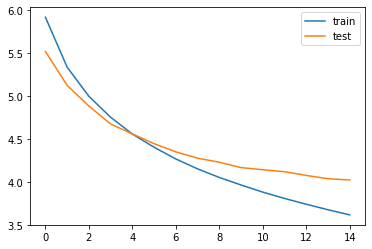

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Fase de Inferência do Modelo

In [ ]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(speech_max_len,400))

# Get the embeddings of the decoder sequence
dec_emb2 = decoder_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
reverse_source_word_index=speech_tokenizer.index_word
reverse_target_word_index=summary_tokenizer.index_word
target_word_index=summary_tokenizer.word_index

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
            sampled_token = 'end'
        else:
            sampled_token = reverse_target_word_index[sampled_token_index]
        # print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (summary_max_len-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString
def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(10,20):
    print(f"Review: {seq2text(x_test[i])}")
    summ = seq2summary(y_test[i])
    print(f"Original summary: {summ}")
    pred_summ = decode_sequence(x_test[i].reshape(1,  speech_max_len))
    print(f"Predicted summary: {pred_summ}")

## Avaliação do modelo

In [ ]:
rouge = Rouge()

data = []
for i in range(len(x_test)):
    summ = seq2summary(y_test[i])
    pred_summ = decode_sequence(x_test[i].reshape(1,speech_max_len))
    rouge_list = [0, 0, 0]
    if len(pred_summ) > 0 and len(summ):
        scores = rouge.get_scores(pred_summ, summ)[0]
        rouge_list = [scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f']]
    data.append([
        seq2text(x_test[i])
        , summ
        , pred_summ
        , rouge_list[0]
        , rouge_list[1]
        , rouge_list[2]
    ])

val_df = pd.DataFrame(data, columns=['speech', 'original_summary', 'predicted_summary', 'rouge_1', 'rouge_2', 'rouge_l'])

In [ ]:
print(f"Rouge-1 average score: {val_df['rouge_1'].mean()}")
print(f"Rouge-2 average score: {val_df['rouge_2'].mean()}")
print(f"Rouge-L average score: {val_df['rouge_l'].mean()}")

Rouge-1 average score: 0.17907017583738444
Rouge-2 average score: 0.06125812653200354
Rouge-L average score: 0.1756311384612113


In [ ]:
_, _, F1 = score(val_data['predicted_summary'].tolist(), val_data['original_summary'].tolist(), lang="pt", verbose=True)
print(f"System level F1 score: {F1.mean():.3f}")
val_data['bertscore'] = F1.tolist()

In [ ]:
val_df.to_csv('/content/drive/My Drive/Colab Notebooks/resumos_teste.csv', index=False)